In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import warnings
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import xarray as xr
import xbudget
import regionate 
import xwmt
import xwmb
import xgcm
import urllib.request
import shutil
import os

In [20]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.9.0 
regionate version 0.5.3 
xwmt version 0.1.0 
xwmb version 0.5.4


In [21]:
# Download data from Zenodo archive

file_name="SOSE_xWMB_data_Weddell_january_2013.nc"
url = 'https://zenodo.org/records/18662191/files/'
destination_path = f"./data/{file_name}"
if not os.path.exists(destination_path):
    print(f"File '{file_name}' being downloaded to {destination_path}.")
    with urllib.request.urlopen(url + file_name) as response, open(destination_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    print(f"File '{file_name}' has completed download to {destination_path}.")
else:
    print(f"File '{file_name}' already exists at {destination_path}. Skipping download.")

File 'SOSE_xWMB_data_Weddell_january_2013.nc' already exists at ./data/SOSE_xWMB_data_Weddell_january_2013.nc. Skipping download.


In [22]:
# Open data set
ds = xr.open_dataset("./data/SOSE_xWMB_data_Weddell_january_2013.nc")

In [23]:
# Create xgcm.Grid instance
coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'},
    }
boundary = {'X':'extend', 'Y':'extend', 'Z':'extend'}
metrics = {('X','Y'):'rA'}

grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata=False)

In [24]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:           (time: 1, z_l: 52, yh: 289, xh: 354, yq: 290,
                       time_bounds: 2, xq: 355, z_i: 53)
Coordinates: (12/52)
  * time              (time) datetime64[ns] 8B 2013-01-15
  * z_l               (z_l) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    drF               (z_l) float32 208B ...
    rhoRef            (z_l) float32 208B ...
    maskZ             (z_l) float64 416B ...
  * yh                (yh) float32 1kB -77.98 -77.95 -77.91 ... -62.73 -62.65
    ...                ...
    rAW               (z_l, yh, xq) float32 21MB ...
    geolon_c          (yq, xq) float64 824kB ...
    geolat_c          (yq, xq) float64 824kB ...
    geolon_u          (yh, xq) float64 821kB ...
    geolat_u          (yh, xq) float64 821kB ...
  * z_i               (z_i) float64 424B 0.0 -4.2 -9.2 ... -5.6e+03 -6e+03
Data variables: (12/30)
    oceFWflx          (time, z_l, yh, xh) float64 43MB ...
    THETA             (time, z_l, yh, xh) float32 21MB ...
    ADVy_TH           (time, z_l, yq, xh) float32 21MB ...
    SALT              (time, z_l, yh, xh) float32 21MB ...
    ADVy_SLT          (time, z_l, yq, xh) float32 21MB ...
    SFLUX             (time, z_l, yh, xh) float64 43MB ...
    ...                ...
    SST               (time, yh, xh) float32 409kB ...
    SSS               (time, yh, xh) float32 409kB ...
    DELTA_ADVh_TH     (time, z_l, yh, xh) float32 21MB ...
    DELTA_DFhE_TH     (time, z_l, yh, xh) float32 21MB ...
    DELTA_ADVh_SLT    (time, z_l, yh, xh) float32 21MB ...
    DELTA_DFhE_SLT    (time, z_l, yh, xh) float32 21MB ...

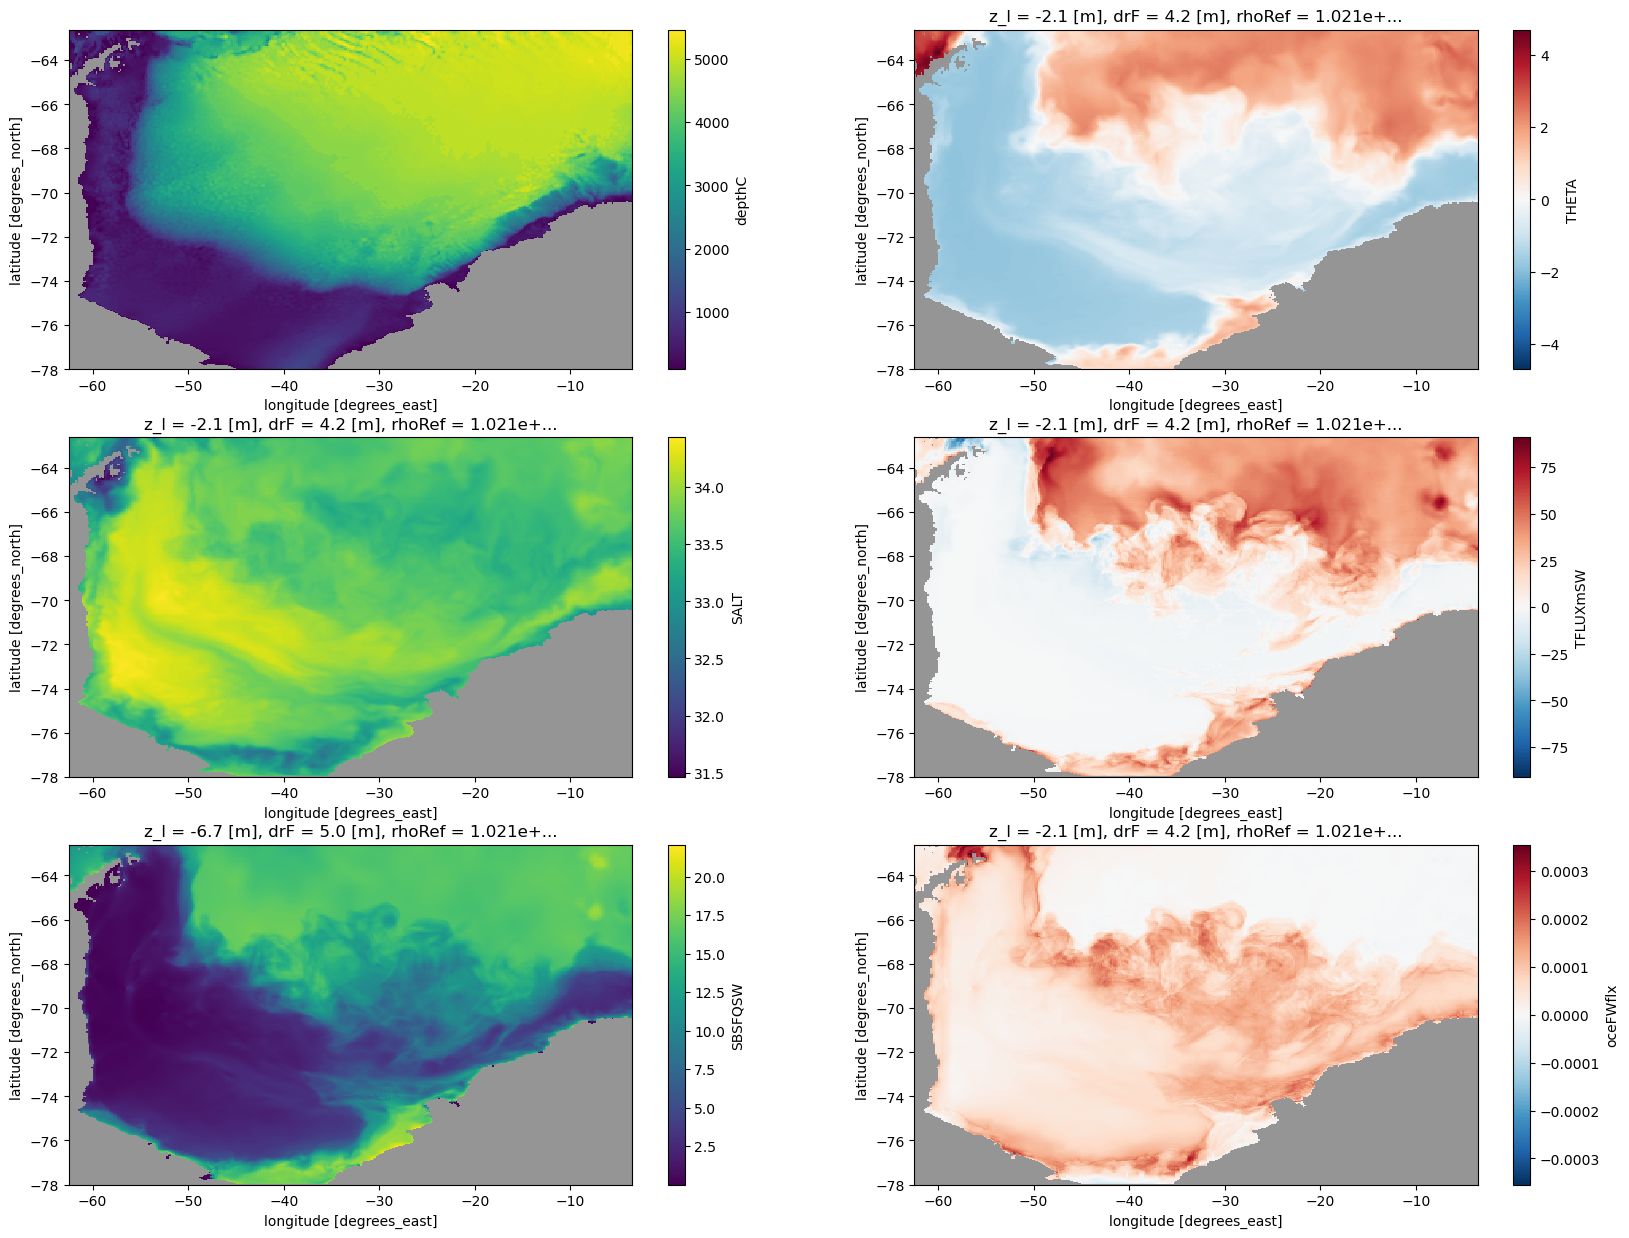

In [25]:
# plot vertically integrated terms

fig,axs=plt.subplots(3,2,figsize=(20,15))

ds.land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.depthC.where(ds.mask2D == 0).plot(ax=axs[0,0])

ds.land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.THETA.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[0,1])

ds.land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.SALT.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[1,0])

ds.land.plot(ax=axs[1,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.TFLUXmSW.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[1,1])

ds.land.plot(ax=axs[2,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.SBSFQSW.isel(time=0,z_l=1).where(ds.mask2D == 0).plot(ax=axs[2,0])

ds.land.plot(ax=axs[2,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.oceFWflx.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[2,1]);


In [26]:
import yaml
with open("./SOSE.yaml", "r") as stream:
    xbudget_dict = yaml.safe_load(stream)

In [27]:
xbudget.collect_budgets(grid, xbudget_dict)

### Budget in density ($\sigma_2$) space

In [28]:
# specific tracer that defines the water mass
lam = "sigma2"

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Instantiate the water mass budget class
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict
    )
    wmb.assert_zero_transport = False

    wmb.mass_budget(lam, greater_than=True,default_bins=[20.,38.,0.1])
    wmt = wmb.wmt.squeeze()
    wmt.load()

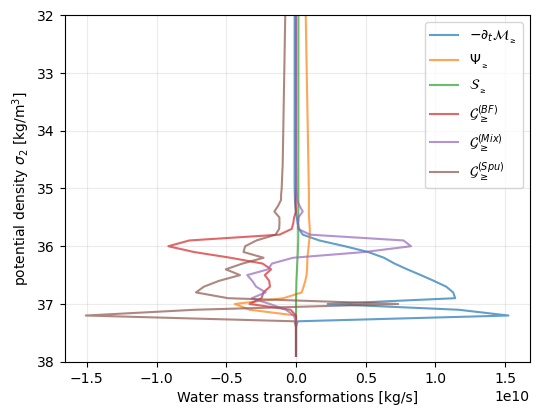

In [29]:
plt.figure(figsize=(6,4.5))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot(-wmt.mass_tendency,                wmt.sigma2_l_target, label=r"$-\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( wmt.convergent_mass_transport,    wmt.sigma2_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.sigma2_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.sigma2_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
#plt.axhline(34, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(38, 32);

### Budget in temperature space

In [30]:
# specific tracer that defines the water mass
lam = "heat"

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Instantiate the water mass budget class
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict
    )
    wmb.assert_zero_transport = False

    wmb.mass_budget(lam, greater_than=False,default_bins=[-3.,5.,0.1])
    wmt = wmb.wmt.squeeze()
    wmt.load()

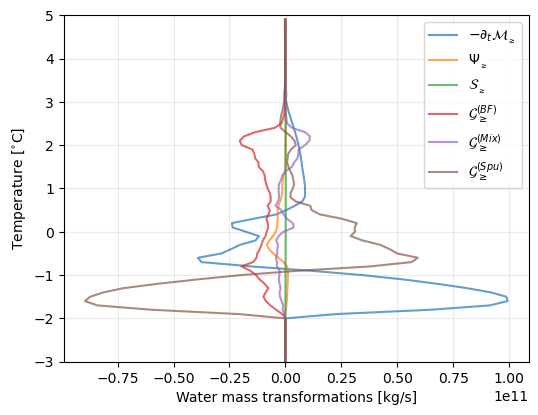

In [31]:
plt.figure(figsize=(6,4.5))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot(-wmt.mass_tendency,                wmt.THETA_l_target, label=r"$-\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( wmt.convergent_mass_transport,    wmt.THETA_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.THETA_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.THETA_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.THETA_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.THETA_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
plt.axhline(34, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"Temperature [$^{\circ}$C]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(-3.,5.);